In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We are using : {device} device")

We are using : cuda device


In [3]:
BASE_PATH = "../TotalLoL"

TRAIN_LOW = os.path.join(BASE_PATH, "train", "low")
TRAIN_HIGH = os.path.join(BASE_PATH, "train", "high")


In [4]:
class IlluminationDataset(Dataset):
    def __init__(self, low_dir, high_dir):
        self.low_images = sorted(os.listdir(low_dir))
        self.high_images = sorted(os.listdir(high_dir))
        self.low_dir = low_dir
        self.high_dir = high_dir

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_path = os.path.join(self.low_dir, self.low_images[idx])
        high_path = os.path.join(self.high_dir, self.high_images[idx])

        low_img = cv2.imread(low_path)
        high_img = cv2.imread(high_path)

        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
        high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)

        low_img = low_img.astype(np.float32) / 255.0
        high_img = high_img.astype(np.float32) / 255.0

        low_img = torch.from_numpy(low_img).permute(2, 0, 1)
        high_img = torch.from_numpy(high_img).permute(2, 0, 1)

        return low_img, high_img


In [5]:
from torch.utils.data import random_split

dataset = IlluminationDataset(TRAIN_LOW, TRAIN_HIGH)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train samples:", train_size)
print("Validation samples:", val_size)


Train samples: 1056
Validation samples: 118


In [6]:
# ✅ Total layers = 6
class IlluminationNet(nn.Module):
    def __init__(self):
        super(IlluminationNet, self).__init__()
    # 256 * 256
    # encoder block 
    # starts here
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
     #ends here  -> Encoder depth: 2 Conv layers

        self.decoder = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()   # Illumination map in [0,1]
        )
        # Decoder depth: 1 Conv layer
        # Total Conv layers = 3
        #Total activation layers = 3 (2 ReLU + 1 Sigmoid)

    def forward(self, x):
        x = self.encoder(x)
        illumination = self.decoder(x)
        return illumination


In [7]:
def correct_illumination(low_img, illumination, eps=1e-4):
    return low_img / (illumination + eps)


In [8]:
def smoothness_loss(illumination):
    dx = torch.abs(illumination[:, :, :, :-1] - illumination[:, :, :, 1:])
    dy = torch.abs(illumination[:, :, :-1, :] - illumination[:, :, 1:, :])
    return torch.mean(dx) + torch.mean(dy)


In [9]:
model = IlluminationNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
l1_loss = nn.L1Loss()
import time
import math
def psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))


In [11]:


train_losses = []
val_losses = []
val_psnrs = []
epoch_times = []



num_epochs = 50
best_val_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    # -------- TRAINING --------
    model.train()
    train_loss = 0.0

    for low_img, high_img in train_loader:
        low_img = low_img.to(device)
        high_img = high_img.to(device)

        illumination = model(low_img)
        corrected = correct_illumination(low_img, illumination)

        loss_recon = l1_loss(corrected, high_img)
        loss_smooth = smoothness_loss(illumination)

        loss = loss_recon + 0.1 * loss_smooth

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    val_psnr = 0.0

    with torch.no_grad():
        for low_img, high_img in val_loader:
            low_img = low_img.to(device)
            high_img = high_img.to(device)

            illumination = model(low_img)
            corrected = correct_illumination(low_img, illumination)

            loss_recon = l1_loss(corrected, high_img)
            loss_smooth = smoothness_loss(illumination)

            loss = loss_recon + 0.1 * loss_smooth

            val_loss += loss.item()
            val_psnr += psnr(corrected, high_img).item()

    val_loss /= len(val_loader)
    val_psnr /= len(val_loader)
    
    epoch_time = time.time() - start_time



    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_psnrs.append(val_psnr)
    epoch_times.append(epoch_time)


    # -------- SAVE BEST MODEL --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../results/illumination_net_best_totalLol_training.pth")

    print(
        f"Epoch [{epoch+1:03d}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val PSNR: {val_psnr:.2f} dB | "
        f"Time: {epoch_time:.2f}s"
    )


Epoch [001/50] | Train Loss: 0.2915 | Val Loss: 0.2474 | Val PSNR: 10.89 dB | Time: 137.62s
Epoch [002/50] | Train Loss: 0.2043 | Val Loss: 0.2157 | Val PSNR: 11.40 dB | Time: 87.07s
Epoch [003/50] | Train Loss: 0.1917 | Val Loss: 0.2107 | Val PSNR: 11.51 dB | Time: 85.10s
Epoch [004/50] | Train Loss: 0.1880 | Val Loss: 0.2047 | Val PSNR: 11.73 dB | Time: 83.63s
Epoch [005/50] | Train Loss: 0.1854 | Val Loss: 0.1972 | Val PSNR: 12.21 dB | Time: 86.15s
Epoch [006/50] | Train Loss: 0.1814 | Val Loss: 0.1926 | Val PSNR: 12.46 dB | Time: 85.71s
Epoch [007/50] | Train Loss: 0.1786 | Val Loss: 0.1885 | Val PSNR: 12.66 dB | Time: 86.56s
Epoch [008/50] | Train Loss: 0.1750 | Val Loss: 0.1862 | Val PSNR: 12.78 dB | Time: 83.91s
Epoch [009/50] | Train Loss: 0.1731 | Val Loss: 0.1830 | Val PSNR: 13.00 dB | Time: 84.78s
Epoch [010/50] | Train Loss: 0.1716 | Val Loss: 0.1830 | Val PSNR: 13.00 dB | Time: 80.96s
Epoch [011/50] | Train Loss: 0.1702 | Val Loss: 0.1804 | Val PSNR: 13.13 dB | Time: 84.13

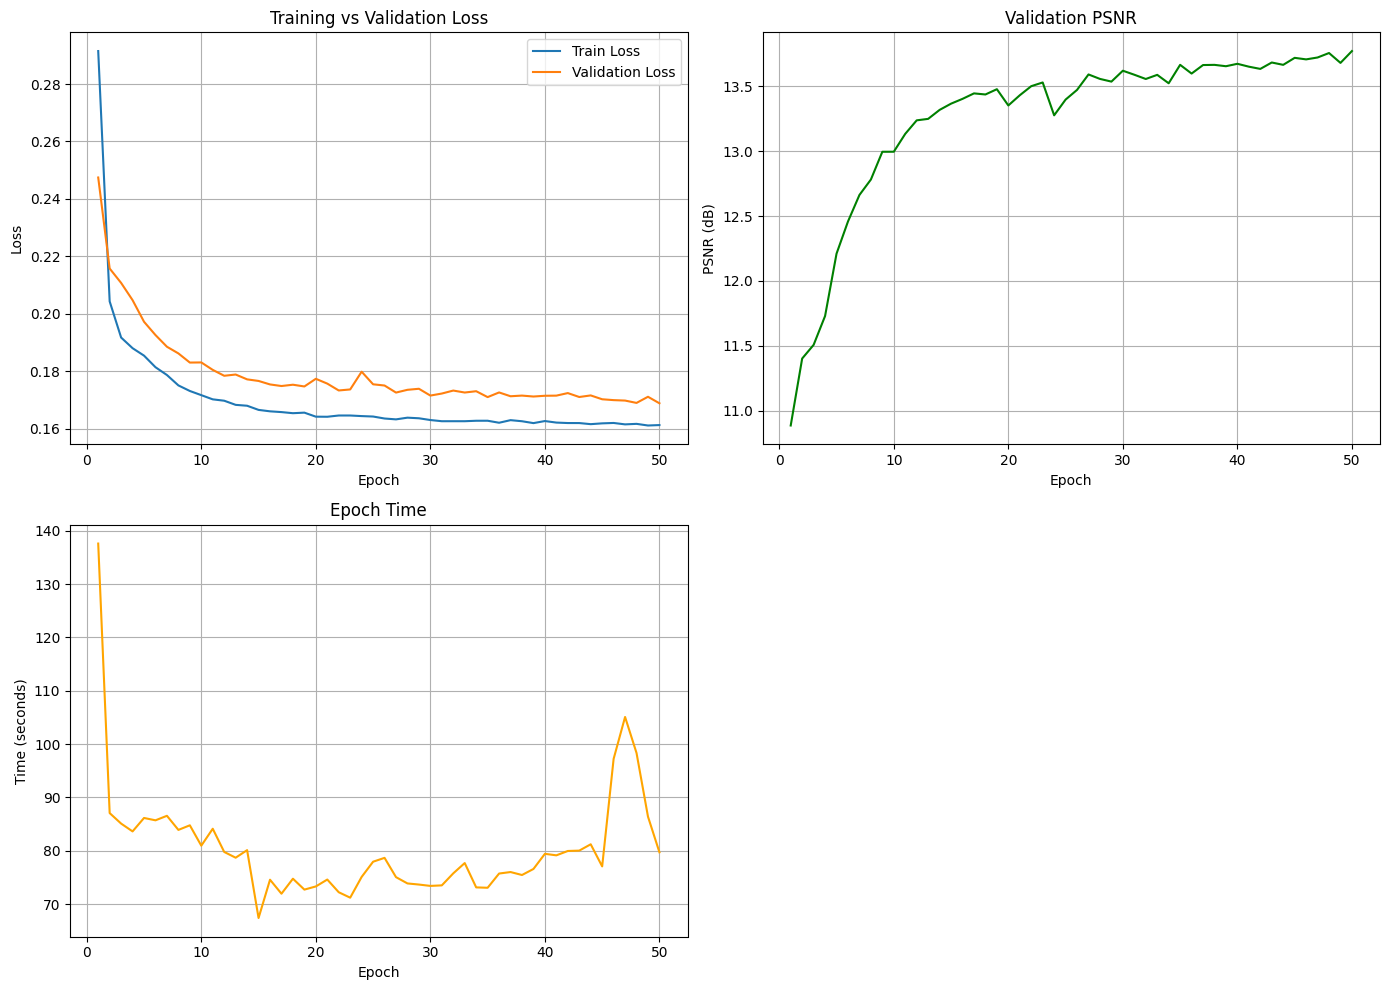

In [12]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14,10))

# ---- Train vs Validation Loss ----
plt.subplot(2,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# ---- Validation PSNR ----
plt.subplot(2,2,2)
plt.plot(epochs, val_psnrs, color="green")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Validation PSNR")
plt.grid(True)

# ---- Epoch Time ----
plt.subplot(2,2,3)
plt.plot(epochs, epoch_times, color="orange")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Epoch Time")
plt.grid(True)

plt.tight_layout()
plt.show()
